In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import lightkurve as lk
from modules import *
from astropy.table import Table
import scipy.signal as signal
import scipy.optimize as optimize
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from tqdm import tqdm

plt.style.use('seaborn-v0_8-darkgrid')

TIC = 'TIC 219107776'

cadence_magnifier = 10
cadence = 120

PREPARING THE DATA
-------------

This section downloads the desired lightcurves and performs some preliminary operations on them. The operations are:

- Removing the NaNs
- Removing the big features (like outbursts, etc.)
- Interpolating (or increasing the cadence of) the lightcurves

In [2]:
#Downloading all the lightcurves as list[LightCurve]

lcs = get_lightcurves(TIC, author = 'SPOC', cadence='short', use_till=10)

SearchResult containing 10 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 14 2019   SPOC     120   219107776      0.0
  1 TESS Sector 15 2019   SPOC     120   219107776      0.0
  2 TESS Sector 16 2019   SPOC     120   219107776      0.0
  3 TESS Sector 17 2019   SPOC     120   219107776      0.0
  4 TESS Sector 18 2019   SPOC     120   219107776      0.0
  5 TESS Sector 20 2019   SPOC     120   219107776      0.0
  6 TESS Sector 26 2020   SPOC     120   219107776      0.0
  7 TESS Sector 24 2020   SPOC     120   219107776      0.0
  8 TESS Sector 21 2020   SPOC     120   219107776      0.0
  9 TESS Sector 23 2020   SPOC     120   219107776      0.0


Gaps at times: [1696.38854348]
Gaps at times: [1721.58580465]
Gaps at times: [1748.68724642]
Gaps at times: [1773.58173744]
Gaps at times: [1791.10954097 1800.4581543 ]
Gaps at times: [1854.85673551]
Gaps at times: [1883.94972909]
Gaps at times: [1935.4565236  1940.87040443]
Gaps at times: [1968.34672375]
Gaps at times: [2022.18973577]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1595140 entries, 0 to 1595139
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   time    1595140 non-null  float64
 1   flux    1595140 non-null  float64
dtypes: float64(2)
memory usage: 24.3 MB


<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux'>

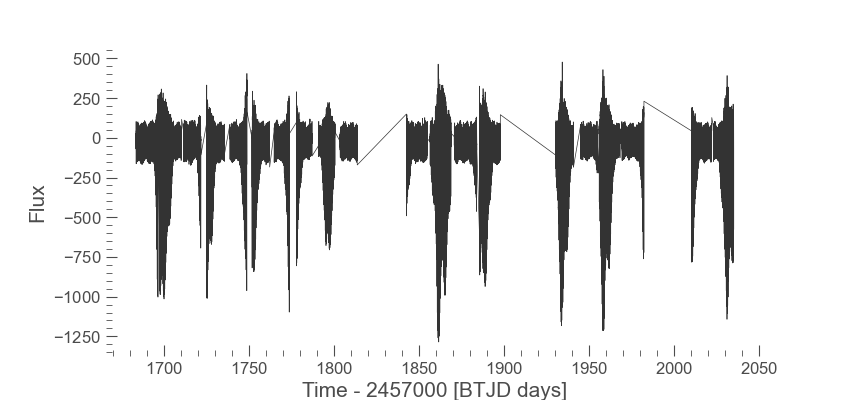

In [3]:
#Preparing the Lightcurves for analysis
new_lcs = []

for lc in lcs:
    #Removing Nans from the Lightcurves
    df = pd.DataFrame({'time': lc.time.jd, 'flux': np.array(lc.flux, dtype='f')}).dropna(inplace=False)
    new_lc = lk.LightCurve(time= df['time'], flux= df['flux'])

    #new_lc = lc.remove_nans()                  #Potential alternative solution
    
    #Removing the big trends AND increasing the cadence.
    new_lc = apply_savgol_filter(new_lc.time.jd, new_lc.flux, want = 'lc', displaygraphs= False, window_length_for_remove=900)
    new_lc = spline_while_jumping_gaps(new_lc, cadence_magnifier= 10)

    #Storing away the adjusted & splined curve
    new_lcs.append(new_lc)

#Combining all the lightcurves into one.
lightcurve = combine_lightcurves(new_lcs)
lightcurve.plot()

Gaps at times: [1696.38854348 1710.20384366 1721.58580465 1735.50111012 1748.68724642
 1762.02199256 1773.58173744 1787.00953195 1791.10954097 1800.4581543
 1813.5789914  1854.85673551 1868.82198619 1883.94972909 1897.78024627
 1935.4565236  1940.87040443 1954.87453664 1968.34672375 1982.28003508
 2022.18973577]


<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux'>

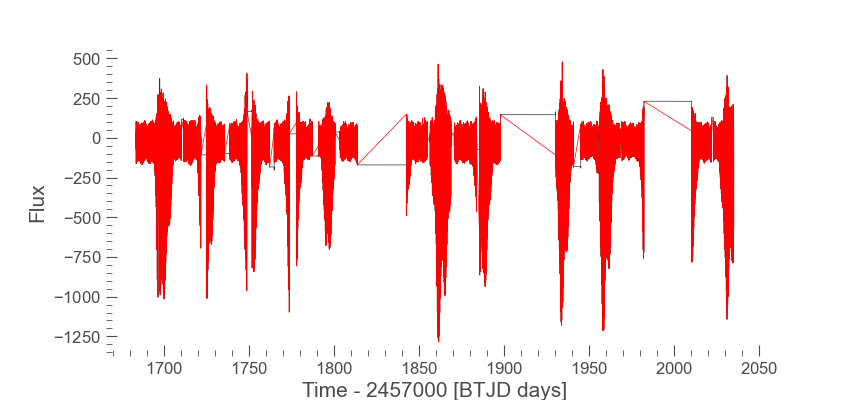

In [21]:
#Fill the gaps with straight lines
new_lightcurve = straight_lines(lightcurve, cadence_magnifier= 1)
axess = new_lightcurve.plot()
lightcurve.plot(ax= axess, color= 'red')

FINDING THE PERIOD
-------------

The next section here finds the period to be used for O-C calculations as well as for folding.
A gaussian curve is fit on a Periodogram that is obtained from the desired `lightcurve`.

Please click on the desired peak to make the program process data, the peak should be the tallest peak in the entire mess of principle peak.

PS: Clicking on a point draws a gaussian which is selected for the O-C calculations. If you miss-clicked, just click on the right point afterwards and it will draw a curve in a different color, allowing you to choose another point.

In [24]:
periodogram = lightcurve.to_periodogram(maximum_frequency = 30)

peak_width = 1 / ( (lightcurve.time.btjd[-1] - lightcurve.time.btjd[0]) * 2)
print(peak_width)
max_power = periodogram.max_power.value
optimized_parameters_global = []

colors = ['red', 'green', 'purple', 'orange', 'yellow', 'pink', 'brown', 'magenta', 'cyan']
def color_change():
    c = colors.pop(0)
    colors.append(c)
    yield c

frequencies = periodogram.frequency.value
power = periodogram.power.value
f = np.linspace(frequencies.min(), frequencies.max(), 1000000)
p = spline(frequencies, power, k = 3)(f)

peaks, peakdict = signal.find_peaks(p, height = max_power/10)
peaks_df = pd.DataFrame({'frequencies': f[peaks], 'power': p[peaks], 'peak_index': peaks})

fi = go.FigureWidget([
    go.Scatter(x=f[peaks], y=p[peaks], mode = 'markers', name = 'Peaks', marker = {
        'symbol': 'x',
        'size': 7,
    }),
    go.Scatter(x=frequencies, y=power, mode='lines', name = 'Periodogram', line = dict(color='black')),
], layout = go.Layout(title = 'Periodogram Peaks', xaxis_title = 'Frequency [1/d]', yaxis_title = 'Power'))

scatter = fi.data[0]
fi.layout.hovermode = 'closest'

def update_point(trace, points, selector):
    for i in points.point_inds:
        initial_guess = [peaks_df['power'][i], peaks_df['frequencies'][i], peak_width]
        optimized_parameters, covariance = optimize.curve_fit(gaussian, frequencies, power, p0=initial_guess)
        amp, cen, wid = optimized_parameters

        fitted_gaussian = gaussian(frequencies, amp, cen, wid)
        initial_gaussian = gaussian(frequencies, *initial_guess)

        fi.add_trace(go.Scatter(x=frequencies, y=fitted_gaussian, mode='lines', name='Fitted Gaussian', line=dict(color=next(color_change()))))
        fi.add_trace(go.Scatter(x=frequencies, y=initial_gaussian, mode='lines', name='Initial Gaussian', line=dict(color=next(color_change()))))
        optimized_parameters_global.append(optimized_parameters)
        print(optimized_parameters_global[-1])
    
scatter.on_click(update_point)
fi


0.0014213413393505908


FigureWidget({
    'data': [{'marker': {'size': 7, 'symbol': 'x'},
              'mode': 'markers',
              'name': 'Peaks',
              'type': 'scatter',
              'uid': '8603b312-90e6-4ef2-a04e-e403d79d8faa',
              'x': array([ 4.65173998,  4.67024963,  4.67855947,  4.6822194 ,  4.69073924,
                           4.69448917,  4.69976907,  4.70309901,  4.70900889,  4.71224883,
                           4.72076867,  4.72472859,  4.72769854,  4.73330843,  4.73654837,
                           4.74197827,  4.74509821,  4.74833814,  4.75124809,  4.75691798,
                           4.75943793,  4.76336786,  4.76714779,  4.76993773,  4.77548763,
                           4.78151751,  4.78457745,  4.79018735,  4.79336729,  4.79918718,
                           4.80188712,  4.80584705,  4.81424689,  4.81748683,  4.82351671,
                           4.82690665,  4.83227655,  4.83599648,  4.84439632,  4.84811624,
                           4.87511573,  4.91942

[7.91463616e+01 4.76335973e+00 1.36955392e-03]


In [25]:
try:
    fitted_frequency = optimized_parameters_global[-1][1]
    fitted_period = 1/fitted_frequency
except:
    raise ValueError('No peaks clicked yet, please click on a peak to fit a gaussian to it.')

print(f'Fitted Frequency: {fitted_frequency}')
print(f'Fitted Period: {fitted_period}')

Fitted Frequency: 4.763359727652936
Fitted Period: 0.2099358556093627


In [26]:
#Dividing the lightcurve into chunks, the size of a chunk is the fitted period.
lightcurve_df = pd.DataFrame({'time': lightcurve.time.btjd, 'flux': np.array(lightcurve.flux, dtype='f')})
curr_initial_time = lightcurve_df['time'].iloc[0]
curr_end_time = curr_initial_time + fitted_period

chunks = []

for i in tqdm(range(2000)):
    if curr_end_time > lightcurve_df['time'].iloc[-1]:
        break
    else:
        #Only the timestamps between initial_time and end_time are stored inside a chunk.
        chunk = lightcurve_df[(lightcurve_df['time'] >= curr_initial_time) & (lightcurve_df['time'] < curr_end_time)]
        curr_initial_time = curr_end_time
        curr_end_time = curr_initial_time + fitted_period
        # plt.figure(num = 2, figsize=(10, 5))
        # plt.plot(chunk['time'], chunk['flux'], lw=0.5)
        # plt.savefig(f'Chunks/{i}.png')
        chunks.append(chunk)


 84%|████████▍ | 1675/2000 [00:03<00:00, 423.43it/s]


In [30]:
pd.DataFrame({
    'chunk' : chunks,
    'chunk_number' : [i for i in range(len(chunks))],
    'chunk_len' : [len(chunk) for chunk in chunks],
}).to_csv('chunks.csv', index=False)

In [33]:
for i, chunk in tqdm(enumerate(chunks[:50])):
    plt.figure(num = 2, figsize=(10, 5))
    plt.plot(chunk['time'], chunk['flux'], lw=0.5)
    plt.savefig(f'ChunksAgain/{i}.png')
    plt.close()

50it [00:05,  9.48it/s]
